# DEEP LEARNING - PRACTICUM 03

- Diego Roca Rodríguez
- Roi Santos Ríos

Wasserstein Generative Adversarial Networks, with Gradient Penalty (WGAN-GP)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import iscomplexobj
from scipy.linalg import sqrtm

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
import tensorflow_hub as hub

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import matplotlib.pyplot as plt

import os
import random
import glob

from utils import display, sample_batch, display_one, display_list

2023-05-11 11:53:22.284005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
CHANNELS = 3

BATCH_SIZE = 64
NUM_FEATURES = 128
Z_DIM = 128


EPOCHS = 2
STEPS_PER_EPOCH = 10


LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "./data/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)
# Repeat the dataset
train_data = train_data.repeat()


Found 202599 files belonging to 1 classes.


2023-05-11 11:53:29.581703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 11:53:29.582545: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# Load the pre-trained Inception v3 model
inception_v3 = hub.KerasLayer('https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5', input_shape=(299, 299, 3))


In [5]:
# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    
    return img


train = train_data.map(lambda x: preprocess(x))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
# Show some faces from the training set
train_sample = sample_batch(train)

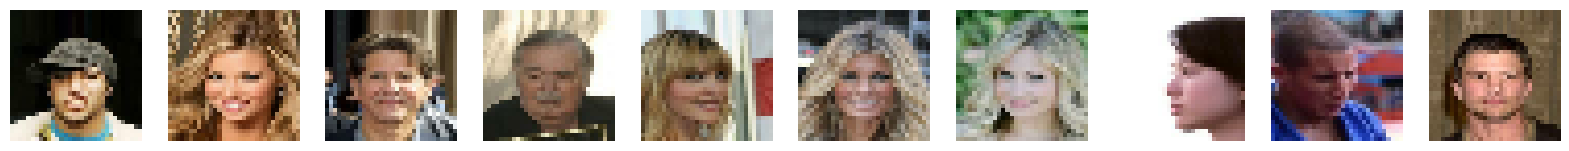

In [7]:
display(train_sample, cmap=None)

## 2. Build the WGAN-GP <a name="build"></a>

In [8]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544

In [9]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        524288    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 256)        1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        5242

In [10]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}
    

In [11]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [12]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [13]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)

In [15]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

We've implemented here the FID calculation, as a Callback class, in order to have the model generate some images and calculate the FID after each epoch, in order to see the evolution of it.

To be able to see the evolution of the FID throughout 

We import the inception_v3 model to perform the encoding of the images, 

In [16]:
class CalculateFid(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    # Define a function to calculate FID
    def calculate_fid(self, real_features, generated_features):
        # Calculate the mean and covariance of the real and generated features
        mu_real = np.mean(real_features, axis=0)
        mu_generated = np.mean(generated_features, axis=0)
        cov_real = np.cov(real_features, rowvar=False)
        cov_generated = np.cov(generated_features, rowvar=False)

        # Calculate the squared difference between the means
        diff = mu_real - mu_generated
        diff_squared = np.dot(diff, diff)

        # Calculate the square root of the product of the covariances
        cov_sqrt = sqrtm(cov_real.dot(cov_generated))
        
        if iscomplexobj(cov_sqrt):
            cov_sqrt = cov_sqrt.real

        # Calculate the FID
        fid = diff_squared + np.trace(cov_real + cov_generated - 2 * cov_sqrt)

        return fid

    def preprocess_inception(self, image):
        image = tf.image.resize(image, (299, 299))
        image = tf.keras.applications.inception_v3.preprocess_input(image)
        return image
    
    def on_epoch_end(self, epoch, logs=None):
        z_sample = np.random.normal(size=(self.num_img, Z_DIM))

        # Generate a batch of images using the model
        generated_images = wgangp.generator.predict(z_sample)

        # Preprocess the images
        preprocessed_images = np.array([self.preprocess_inception(image) for image in generated_images])

        # Extract features from the images
        generated_features = inception_v3(preprocessed_images)
        generated_features = tf.keras.backend.eval(generated_features)

        print("GENERATED IMAGES, EPOCH: ", epoch)
        display(generated_images, cmap=None)
        
        #Load 10 images at random from the directory "./data/img_align_celeba"
        real_images = np.array([tf.keras.preprocessing.image.img_to_array(
            tf.keras.preprocessing.image.load_img(image_path, target_size=(32, 32)))
                                for image_path in np.random.choice(
                                    glob.glob("./data/img_align_celeba/*.jpg"), self.num_img)])
        
        # Preprocess the images
        preprocessed_images = np.array([self.preprocess_inception(image) for image in real_images])

        # Extract features from the images
        real_features = inception_v3(preprocessed_images)
        real_features = tf.keras.backend.eval(real_features)

        #print(real_features.shape)
        print("REAL IMAGES, EPOCH: ", epoch)
        display_list(real_images)
        
        # Calculate the FID
        fid = self.calculate_fid(real_features, generated_features)
        print("-------------------------")
        print("EPOCH: ", epoch, " FID: ", fid)
        
calculate_fid = CalculateFid(num_img=10, latent_dim=Z_DIM)

Epoch 1/2
1/1 [==============================] - 0s 147ms/step_loss: -8.8702 - c_wass_loss: -12.5393 - c_gp: 0.3669 - g_loss: -0.7715 - c_acc: 100.0000 - g_acc: 31.09
GENERATED IMAGES, EPOCH:  0


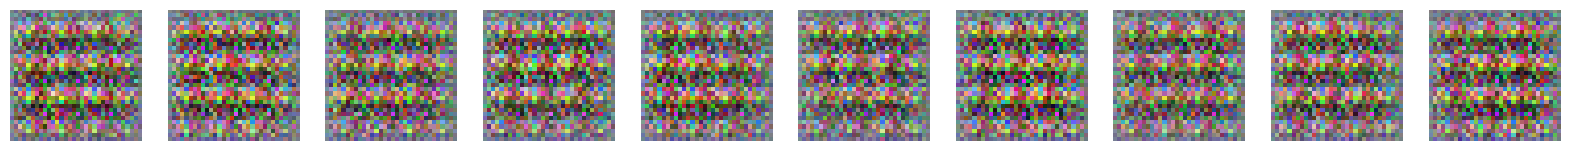

REAL IMAGES, EPOCH:  0


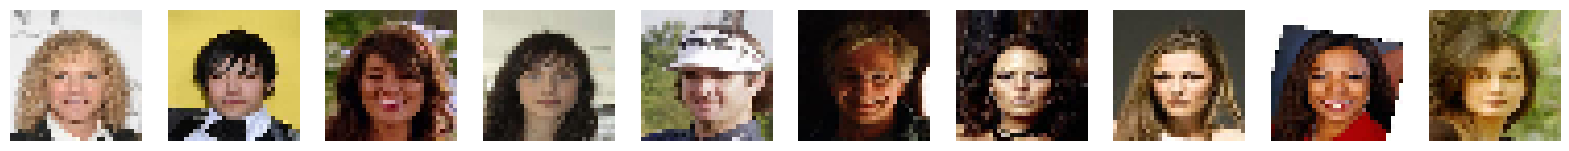

-------------------------
EPOCH:  0  FID:  627.1632982587571
10/10 [==============================] - 23s 2s/step - c_loss: -8.8702 - c_wass_loss: -12.5393 - c_gp: 0.3669 - g_loss: -0.7715 - c_acc: 100.0000 - g_acc: 31.2500
Epoch 2/2
1/1 [==============================] - 0s 54ms/stepc_loss: -34.0608 - c_wass_loss: -44.0147 - c_gp: 0.9954 - g_loss: 4.0150 - c_acc: 100.0000 - g_acc: 95.62
GENERATED IMAGES, EPOCH:  1


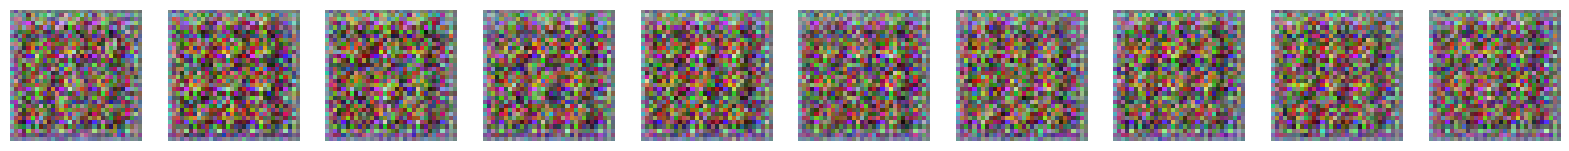

REAL IMAGES, EPOCH:  1


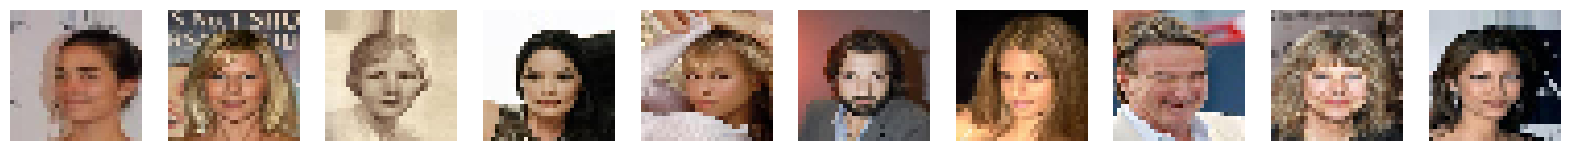

-------------------------
EPOCH:  1  FID:  739.3788510886889
10/10 [==============================] - 21s 2s/step - c_loss: -34.0608 - c_wass_loss: -44.0147 - c_gp: 0.9954 - g_loss: 4.0150 - c_acc: 100.0000 - g_acc: 96.0227


In [17]:
loss_history = LossHistory()

wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[model_checkpoint_callback, tensorboard_callback, calculate_fid, loss_history],
)

In [18]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/generator/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


INFO:tensorflow:Assets written to: ./models/critic/assets


# 4. Results

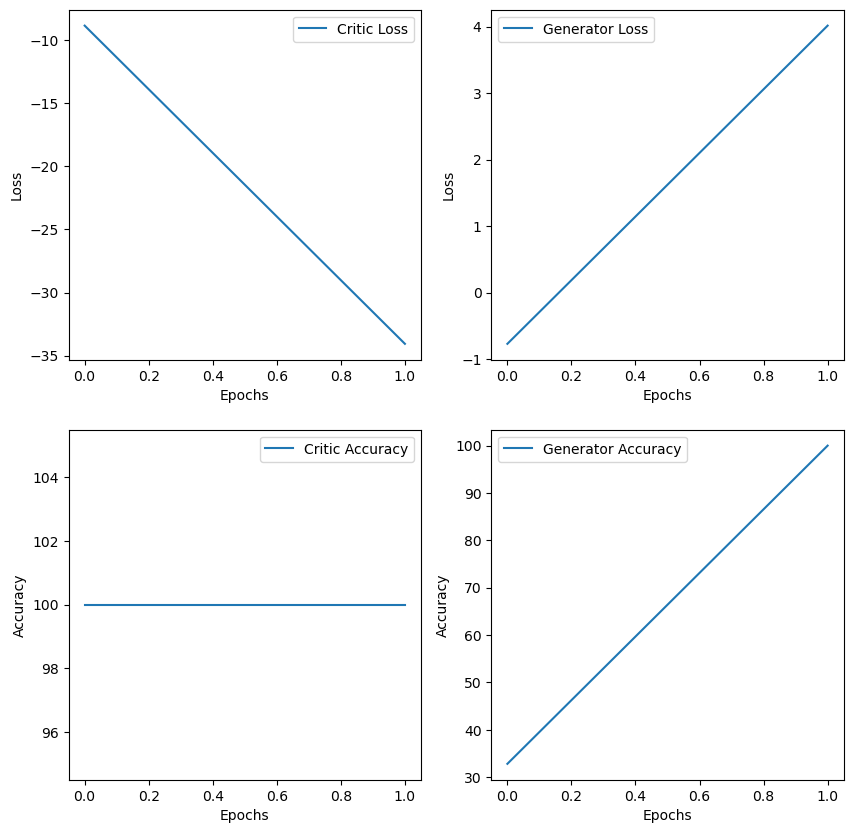

In [19]:
def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    
    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()
    
    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()
    
    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()
    
    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)